### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import csv
import datetime
import itertools
import json
import os
import tarfile
import zipfile
from shutil import copy, copyfile
from textwrap import wrap
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from google.colab import drive
from keras_preprocessing.image import ImageDataGenerator
from numpy import argmax
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        TensorBoard)
from tensorflow.keras.metrics import (AUC, CategoricalAccuracy,
                                      CategoricalCrossentropy, FalseNegatives,
                                      FalsePositives,
                                      MeanAbsolutePercentageError, Precision,
                                      Recall, TrueNegatives, TruePositives)
from tensorflow.keras.models import load_model
from tensorflow_addons.metrics import F1Score

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AG90EgcSeX2jUylzXoHGAmN2VjQY7wWSQglgROiKP81wvn6FiB_f64
Mounted at /content/drive


### Download dataset

In [2]:
import os

dataset_url = "http://aisdatasets.informatik.uni-freiburg.de/" \
              "freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"

print("Downloading dataset.")
urlretrieve(dataset_url, "./freiburg_groceries_dataset.tar.gz")
print("Done.")

Done.


In [3]:
!rm -rf /content/images
tar = tarfile.open('/content/freiburg_groceries_dataset.tar.gz', 'r')
tar.extractall('/content')

### Preprocessing


In [4]:
dataset_path = '/content/images'
new_path = '/content/freiburg_groceries_dataset'
train_path = '/content/freiburg_groceries_dataset/train'
validation_path = '/content/freiburg_groceries_dataset/validation'
evaluation_path = '/content/freiburg_groceries_dataset/evaluation'

if not os.path.exists(new_path):
    os.makedirs(new_path)

if not os.path.exists(train_path):
    os.makedirs(train_path)
    os.makedirs(os.path.join(train_path, 'images'))

if not os.path.exists(validation_path):
    os.makedirs(validation_path)
    os.makedirs(os.path.join(validation_path, 'images'))

if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
    os.makedirs(os.path.join(evaluation_path, 'images'))

In [5]:
dataset = {
  'file_name': [], 
  'label': []
}

for product in os.listdir(dataset_path):
  for product_file in os.listdir(os.path.join(dataset_path, product)):
    dataset['file_name'].append(os.path.join(dataset_path, product, product_file))
    dataset['label'].append(product)

dataset_df = pd.DataFrame(dataset, columns=['file_name', 'label'])

In [6]:
train_validate_filenames, evaluation_filenames, train_validate_labels, evaluation_labels = train_test_split(dataset_df['file_name'], dataset_df['label'], train_size=0.8, random_state=42, stratify=dataset_df['label'])

train_validate_df = pd.DataFrame(zip(train_validate_filenames, train_validate_labels), columns=['file_name', 'label'])

train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(train_validate_df['file_name'], train_validate_df['label'], train_size=0.875, random_state=42, stratify=train_validate_df['label'])

train_df = pd.DataFrame(zip(train_filenames, train_labels), columns=['file_name', 'label'])

validation_df = pd.DataFrame(zip(validation_filenames, validation_labels), columns=['file_name', 'label'])

evaluation_df = pd.DataFrame(zip(evaluation_filenames, evaluation_labels), columns=['file_name', 'label'])

In [7]:
with open(os.path.join(train_path, 'train.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(train_filenames, train_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(train_path, 'images', split[-1]))

In [8]:
with open(os.path.join(validation_path, 'validation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(validation_filenames, validation_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(validation_path, 'images', split[-1]))

In [9]:
with open(os.path.join(evaluation_path, 'evaluation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(evaluation_filenames, evaluation_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(evaluation_path, 'images', split[-1]))

#### Define data augmentations

Found 3462 validated image filenames belonging to 25 classes.
Found 495 validated image filenames belonging to 25 classes.
Found 990 validated image filenames belonging to 25 classes.


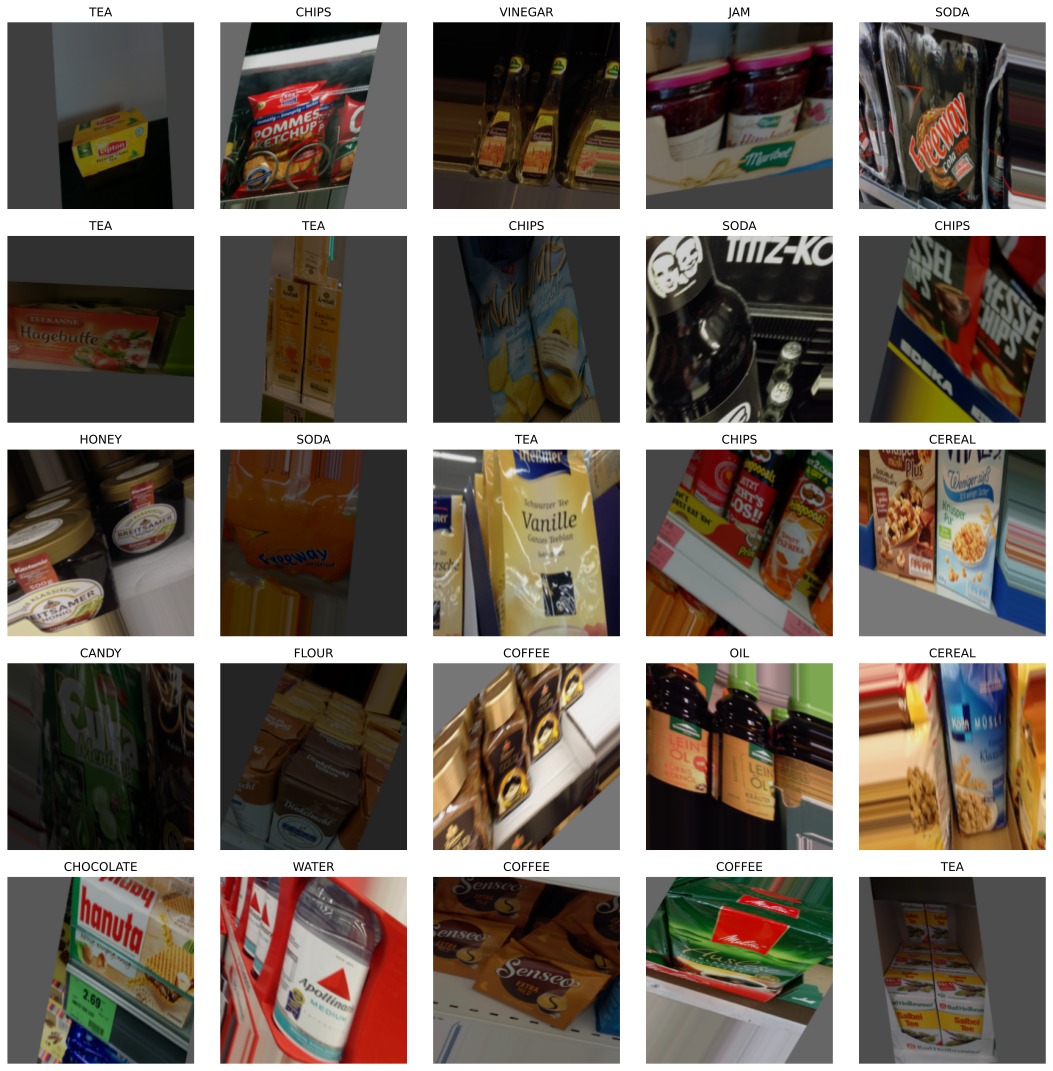

In [11]:
IMG_SIZE = 256
BATCH_SIZE = 128

train_df = pd.read_csv(os.path.join(train_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(validation_path, 'validation.csv'))
evaluation_df = pd.read_csv(os.path.join(evaluation_path, 'evaluation.csv'))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=25,  
    zoom_range = 0.5,
    shear_range = 30,
    width_shift_range=0.15,  
    height_shift_range=0.15,
    brightness_range=[0.25,1.0],
    horizontal_flip=False,  
    vertical_flip=False,
    rescale=1. / 255)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=os.path.join(train_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df, directory=os.path.join(validation_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(dataframe=evaluation_df, directory=os.path.join(evaluation_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

class_indices = evaluation_generator.class_indices
class_indices_inverted = {v: k for k, v in class_indices.items()}

x,y = train_generator.next()

fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
num = 0
for i in range(5):
  for j in range (5):
    ax[i,j].imshow(x[num])
    inverted = class_indices_inverted[argmax(y[num])]
    ax[i,j].set_title("\n".join(wrap(inverted, 10)))
    ax[i,j].axis('off')
    num += 1
  num += 1
        
plt.tight_layout()

#### Save the mapping of the classes into a json file

In [ ]:
indices = train_generator.class_indices
with open('indices.json', 'w') as indices_json:
    json.dump(indices, indices_json)

### Define Callbacks and Metrics

In [ ]:
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('content', 'training', cur_date)
model_filename = 'weights.hdf5'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

callbacks = []
early_stopping = EarlyStopping(
  monitor='val_auc_pr',
  verbose=1, 
  patience=10, 
  mode='max', 
  restore_best_weights=True)

callbacks.append(early_stopping)

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard)
model_checkpoint = ModelCheckpoint(model_filename, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch', 
)
callbacks.append(model_checkpoint)

num_classes = len(train_generator.class_indices)

metrics = [CategoricalAccuracy(name='categorical_accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc_pr', curve='PR'),
    AUC(name='auc_roc', curve='ROC'),
    F1Score(name='f1score', num_classes=num_classes), 
    TrueNegatives(name='tn'), 
    TruePositives(name='tp'), 
    FalseNegatives(name='fn'), 
    FalsePositives(name='fp')]

### Define model

#### Create base model with ImageNet weights

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet',
                                         )
base_model.trainable = False

219062272/219055592 [==============================] - 1s 0us/step


#### Define layers for new classifier

In [ ]:
regularizer = tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001)
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
dropout_layer = tf.keras.layers.Dropout(0.3)
dense = tf.keras.layers.Dense(2048, activation='relu')
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax', activity_regularizer=regularizer)

#### Build the model

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = global_average_pooling_layer(x)
x = dropout_layer(x)
x = dense(x)
y = prediction_layer(x)

model = tf.keras.Model(inputs, y)

In [ ]:
base_learning_rate = 0.00005
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              3147776   
_________________________________________________________________
dense_1 (Dense)              (None, 25)                51225     
Total params: 57,535,737
Trainable params: 3,199,001
Non-trainable params: 54,336,736
__________________________________

### Training

#### Initial training with frozen base model layers to fit the new classifier

In [ ]:
num_epochs = 300

history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator,  callbacks=callbacks)

Epoch 1/300
 1/28 [>.............................] - ETA: 0s - loss: 3.5269 - categorical_accuracy: 0.0391 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc_pr: 0.0374 - auc_roc: 0.4673 - f1score: 0.0037 - tn: 3072.0000 - tp: 0.0000e+00 - fn: 128.0000 - fp: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
28/28 [==============================] - ETA: 0s - loss: 3.1015 - categorical_accuracy: 0.1202 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc_pr: 0.0835 - auc_roc: 0.6342 - f1score: 0.0714 - tn: 83088.0000 - tp: 0.0000e+00 - fn: 3462.0000 - fp: 0.0000e+00
Epoch 00001: val_auc_pr improved from -inf to 0.26007, saving model to weights.hdf5
28/28 [==============================] - 86s 3s/step - loss: 3.1015 - categorical_accuracy: 0.1202 - precisio

#### Save training hisory to a json file

In [ ]:
hist_df = pd.DataFrame(history.history) 

hist_json_file = '/content/history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

### Fine-tuning

#### Definition of callbacks for fine-tuning

In [ ]:
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join('content', 'training', cur_date)
model_filename_ft = 'fine_tuning_weights.hdf5'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

callbacks_ft = []
early_stopping_ft = EarlyStopping(
  monitor='val_auc_pr',
  verbose=1, 
  patience=10, 
  mode='max', 
  restore_best_weights=True)

callbacks_ft.append(early_stopping_ft)

tensorboard_ft = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks_ft.append(tensorboard_ft)
model_checkpoint_ft = ModelCheckpoint(model_filename_ft, 
                                   monitor='val_auc_pr', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   mode='max', 
                                   save_freq='epoch', 
)
callbacks_ft.append(model_checkpoint_ft)

#### Recompile model with unfrozen base model layers

In [ ]:
base_model.trainable = True

base_learning_rate = 0.000001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              3147776   
_________________________________________________________________
dense_4 (Dense)              (None, 25)                51225     
Total params: 57,535,737
Trainable params: 57,475,193
Non-trainable params: 60,544
_____________________________________

In [ ]:
fine_tune_epochs = 25

total_epochs =  history.epoch[-1] + 1 + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator, callbacks=callbacks_ft)

Epoch 1/25
  1/217 [..............................] - ETA: 0s - loss: 1.2885 - categorical_accuracy: 0.5625 - precision: 0.8182 - recall: 0.5625 - auc_pr: 0.7379 - auc_roc: 0.9382 - f1score: 0.2493 - tn: 382.0000 - tp: 9.0000 - fn: 7.0000 - fp: 2.0000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
217/217 [==============================] - ETA: 0s - loss: 1.2373 - categorical_accuracy: 0.6231 - precision: 0.8044 - recall: 0.4526 - auc_pr: 0.6835 - auc_roc: 0.9620 - f1score: 0.6163 - tn: 82707.0000 - tp: 1567.0000 - fn: 1895.0000 - fp: 381.0000
Epoch 00001: val_auc_pr improved from -inf to 0.77388, saving model to fine_tuning_weights.hdf5
217/217 [==============================] - 113s 522ms/step - loss: 1.2373 - categorical_accuracy: 0.6231 - precision: 0.8044

#### Save fine-tuning history to a json file

In [ ]:
hist_ft_df = pd.DataFrame(history_fine.history) 

hist_ft_json_file = '/content/history_fine.json'
with open(hist_ft_json_file, mode='w') as f:
    hist_ft_df.to_json(f)

### Evaluation

In [ ]:
evaluation = model.evaluate(evaluation_generator)

evaluation_data_df = pd.DataFrame(evaluation) 

evaluation_json_file = '/content/evaluation.json'
with open(evaluation_json_file, mode='w') as f:
    evaluation_data_df.to_json(f)

### Save and load model

In [ ]:
model_path =  '/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_{}.h5'.format(datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S"))
model.save(model_path) 
model_path

In [ ]:
model = load_model(model_path)

### Plot confusion matrix

In [ ]:
# from https://deeplizard.com/learn/video/km7pxKy4UHU
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues, file_name='confusion_matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(16,16))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join('/content', file_name) + '.svg')

In [ ]:
def get_image (path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = np.array(img).astype('float32')/255
    x = np.expand_dims(x, axis=0)
    return x

In [ ]:
class_numbers_predicted = []
class_numbers_actual = []

labels_ = evaluation_df.groupby("label")
for label in labels_:
  for path in label[1]["file_name"]:
    x = get_image(os.path.join(evaluation_path, 'images', path))
    p = model.predict(x)
    predicted = class_indices_inverted[argmax(p)]
    class_numbers_predicted.append(argmax(p))
    actual = label[0]
    class_numbers_actual.append(class_indices[actual])

Confusion matrix, without normalization


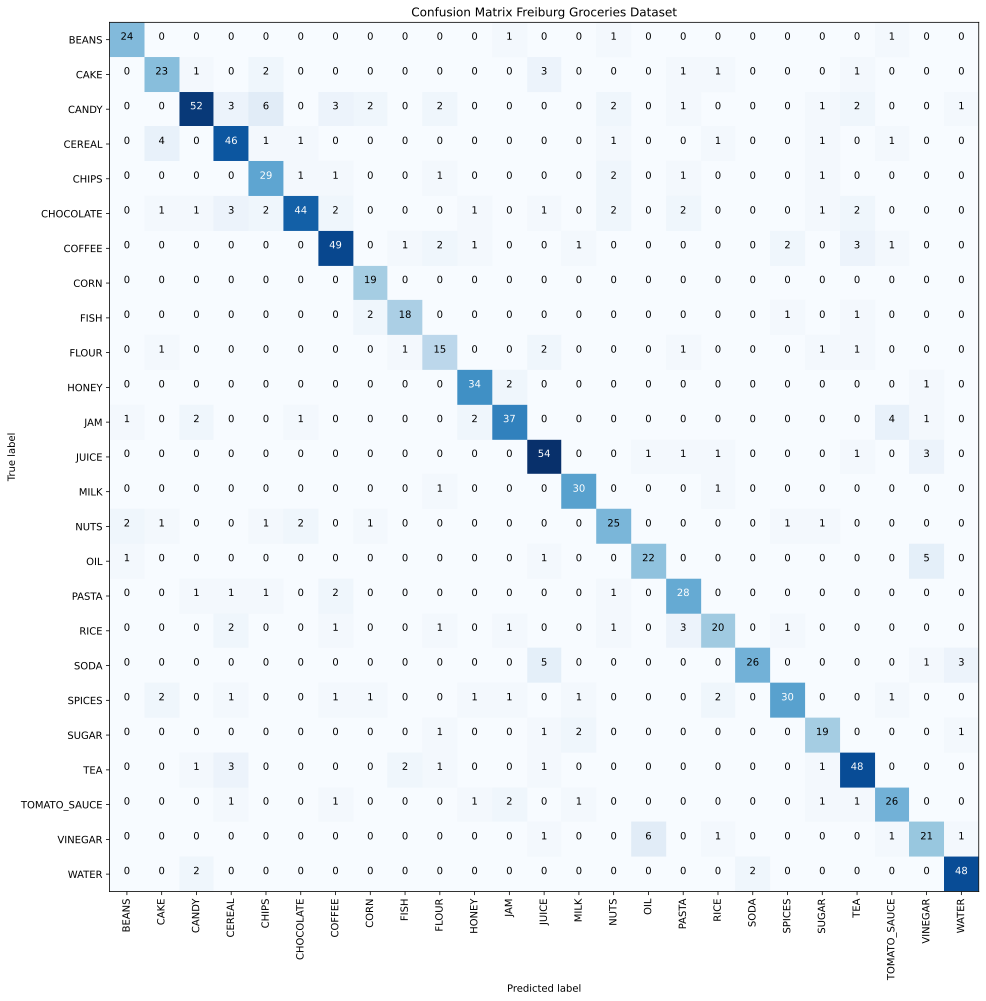

In [ ]:
cm = confusion_matrix(y_true=class_numbers_actual, y_pred=class_numbers_predicted)
cm_plot_labels = evaluation_generator.class_indices
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix Freiburg Groceries Dataset', file_name='confusion_matrix_freiburg_groceries_dataset')